In [1]:
from src.eda import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error


In [2]:
sns.set_theme()

## baseline

### load data

(2337, 10)


car_id           model  car_type fuel_type  car_rating  \
1173  j18260546M        Fiat 500  business    petrol        3.38   
24    i31421704Y  Renault Kaptur  standart    petrol        5.34   
1767  c54659423P       VW Tiguan   economy    petrol        4.86   

      year_to_start  riders  year_to_work  target_reg     target_class  
1173           2013   44911          2021     2439.59  engine_overheat  
24             2013   51207          2017     3352.57     engine_check  
1767           2013   39123          2019      834.26       gear_stick

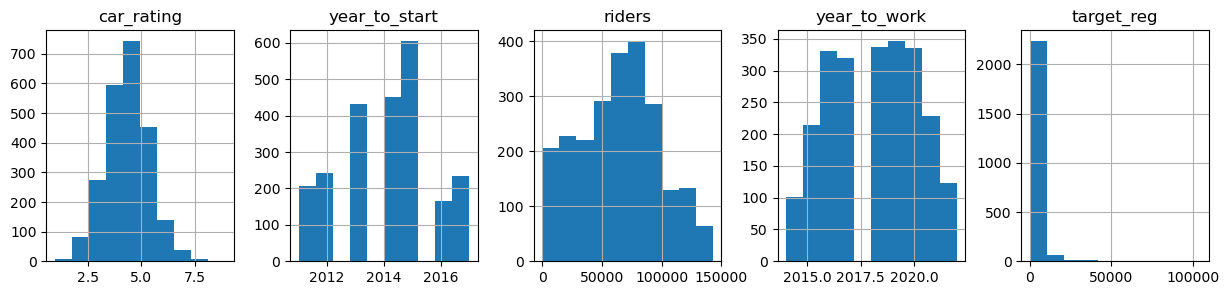

In [7]:
path = './data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(15, 3), layout = (-1, 5))
train.sample(3)

In [8]:
path = './data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


car_id            model  car_type fuel_type  car_rating  \
1119  L-1156474z    Tesla Model 3   premium   electro        4.46   
1211  v-1523714V       VW Polo VI   economy    petrol        5.88   
1089  Q-1583701a  Renault Sandero  standart    petrol        5.84   

      year_to_start  riders  year_to_work  
1119           2013   39718          2022  
1211           2012   23653          2015  
1089           2013   55500          2016

In [9]:
cars = pd.read_csv('./data/fix_info.csv')
drivers = pd.read_csv('./data/driver_info.csv')

### сols setup

In [10]:
features2drop = ['car_id']
targets = ['target_class', 'target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


### baseline 1

In [38]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test),
    verbose=150, plot=False
)

y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 97.9ms	remaining: 1m 37s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 3.43s	remaining: 19.3s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 7.28s	remaining: 16.9s
450:	learn: 0.9685364	test: 2.4038621	best: 2.1908935 (6)	total: 11.1s	remaining: 13.5s
600:	learn: 0.7432300	test: 2.4962387	best: 2.1908935 (6)	total: 15.6s	remaining: 10.3s
750:	learn: 0.5835086	test: 2.5783601	best: 2.1908935 (6)	total: 20.2s	remaining: 6.7s
900:	learn: 0.4589187	test: 2.6654857	best: 2.1908935 (6)	total: 24.8s	remaining: 2.72s
999:	learn: 0.3990111	test: 2.7166606	best: 2.1908935 (6)	total: 27.8s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [44]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('./subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


### baseline 2

In [89]:
file_path = "/data/projects/4_kaggle/carsharing/data/rides_info.csv"
rides = load_data(file_path)
rides = rides.sort_values(['car_id', 'ride_date'])
rides.sample(3)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
345698  W15591027n  Y74292605C     a1W  2020-03-12    4.87             48   
619714  j98528463c  r67742622z     u1k  2020-02-23    5.77             47   
411351  g20255742B  d-1979148g     K1i  2020-01-09    4.77             32   

        ride_cost  speed_avg   speed_max  stop_times     distance  refueling  \
345698        427         66   77.320306           0  1144.728698          0   
619714        747         55  152.005836           0  2365.970364          0   
411351        347         45   57.000000           2  1217.628312          0   

        user_ride_quality  deviation_normal  
345698         -29.226401            37.464  
619714          -7.840627            -4.597  
411351          -0.996449             1.448

In [91]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    rating_min = ('rating', 'min'),
    distance_sum = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    speed_max_p90 = ('speed_max', lambda x: np.percentile(x, 90)),
    speed_avg_p90 = ('speed_avg', lambda x: np.percentile(x, 90)),
    user_ride_quality_median = ('user_ride_quality', 'median'), 
    deviation_normal_median = ('deviation_normal', 'median'),
    deviation_normal_last_30 = ('deviation_normal', lambda x: np.median(x[-30:])),
    user_uniq = ('user_id', f),
    
)


rides_df_gr.head(2)

car_id  mean_rating  rating_min  distance_sum   speed_max  \
0  A-1049127W     4.255172         0.1  1.125753e+07  179.729652   
1  A-1079539w     4.088046         0.1  1.912765e+07  184.505566   

   speed_max_p90  speed_avg_p90  user_ride_quality_median  \
0     142.000000           71.0                 -0.288229   
1     150.552355           72.0                  2.508746   

   deviation_normal_median  deviation_normal_last_30  user_uniq  
0                  -4.4470                   -0.8375        172  
1                  54.2955                   53.2500        173

In [92]:
def add_featues(df):
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [93]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 14 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'rating_min', 'distance_sum', 'speed_max', 'speed_max_p90', 'speed_avg_p90', 'user_ride_quality_median', 'deviation_normal_median', 'deviation_normal_last_30', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


In [94]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.7099805	test: 1.7077437	best: 1.7077437 (0)	total: 51ms	remaining: 50.9s
150:	learn: 0.1429446	test: 0.2740157	best: 0.2733035 (129)	total: 6.49s	remaining: 36.5s
300:	learn: 0.0789085	test: 0.2641158	best: 0.2610922 (228)	total: 13.2s	remaining: 30.6s
450:	learn: 0.0509696	test: 0.2622327	best: 0.2610922 (228)	total: 20.7s	remaining: 25.2s
600:	learn: 0.0360891	test: 0.2688514	best: 0.2610922 (228)	total: 28.2s	remaining: 18.7s
750:	learn: 0.0270811	test: 0.2748561	best: 0.2610922 (228)	total: 35.8s	remaining: 11.9s
900:	learn: 0.0211663	test: 0.2796750	best: 0.2610922 (228)	total: 43.4s	remaining: 4.77s
999:	learn: 0.0181799	test: 0.2816883	best: 0.2610922 (228)	total: 49.3s	remaining: 0us

bestTest = 0.2610921693
bestIteration = 228

Shrink model to first 229 iterations.

 Accuracy: 0.8995726495726496


In [95]:
fi = clf.get_feature_importance(prettified=True)
fi

Feature Id  Importances
0              speed_max_p90    38.726159
1              speed_avg_p90    19.071414
2                mean_rating    13.982985
3                  speed_max    12.983062
4                      model     2.775720
5                 rating_min     2.308545
6   deviation_normal_last_30     1.663622
7                  user_uniq     1.618904
8                   car_type     1.533953
9    deviation_normal_median     0.935531
10  user_ride_quality_median     0.906223
11                    riders     0.856141
12             year_to_start     0.797378
13              distance_sum     0.789916
14                car_rating     0.655299
15              year_to_work     0.339837
16                 fuel_type     0.055312

In [97]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('./subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


## eda

In [103]:
# sns.relplot()
# sns.displot()
# sns.heatmap()
# sns.catplot()

### load data

In [3]:
rides_info  = pd.read_csv('./data/rides_info.csv')
cars = pd.read_csv('./data/car_train.csv')
drivers = pd.read_csv('./data/driver_info.csv')

In [4]:
drivers

age  user_rating  user_rides  user_time_accident     user_id  sex  \
0       27          9.0         865                19.0  l17437965W    1   
1       46          7.9        2116                11.0  Z12362316j    0   
2       59          7.8         947                 4.0  g11098715c    0   
3       37          7.0          18                 4.0  U12618125q    0   
4       39          8.2         428                 7.0  A14375829B    0   
...    ...          ...         ...                 ...         ...  ...   
15148   19          7.9          52                12.0  R13807707w    1   
15149   40          7.6        1142                 3.0  F86199947G    0   
15150   27          7.9        1280                 3.0  O10119419p    1   
15151   30          7.9          31                 5.0  B35483077Y    0   
15152   18          7.8          83                 0.0  S19178709w    1   

      first_ride_date  
0            2019-4-2  
1          2021-11-19  
2           2021-1-15  
3          2019-11-20  
4           2019-7-23  
...               ...  
15148       2019-12-1  
15149       2019-1-18  
15150       2018-9-16  
15151      2019-11-23  
15152      2019-10-23  

[15153 rows x 7 columns]

In [5]:
rides_info.sample(3)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
53462   K87864742g  D17587481H     L1O  2020-01-24    0.87            123   
671311  G32675529C  v-3839326y     a1o  2020-01-11    4.06             46   
33468   K11746403i  C-1753458i     z1G  2020-02-02    4.50             51   

        ride_cost  speed_avg   speed_max  stop_times     distance  refueling  \
53462        1102         49  136.812496           0  3838.794065          0   
671311        501         48   68.000000           3   898.104593          0   
33468         556         42   53.000000           2  1305.122741          0   

        user_ride_quality  deviation_normal  
53462          -12.848450           -13.454  
671311           3.449791             3.206  
33468          -11.750331             0.938

In [6]:
rides_info['distance_delta'] = rides_info['speed_avg'] * rides_info['ride_duration'] - rides_info['distance']
rides_info['log_distance_delta'] = rides_info['distance_delta'].apply(lambda x: np.log(np.abs(x)) * np.sign(x))

In [7]:
fixes = pd.read_csv('./data/fix_info.csv')

### rides + cars + drivers

In [8]:
rides_info = rides_info.merge(cars, on='car_id', how='right')
rides_info = rides_info.merge(drivers, on='user_id', how='left')

#### 1d disrtibution

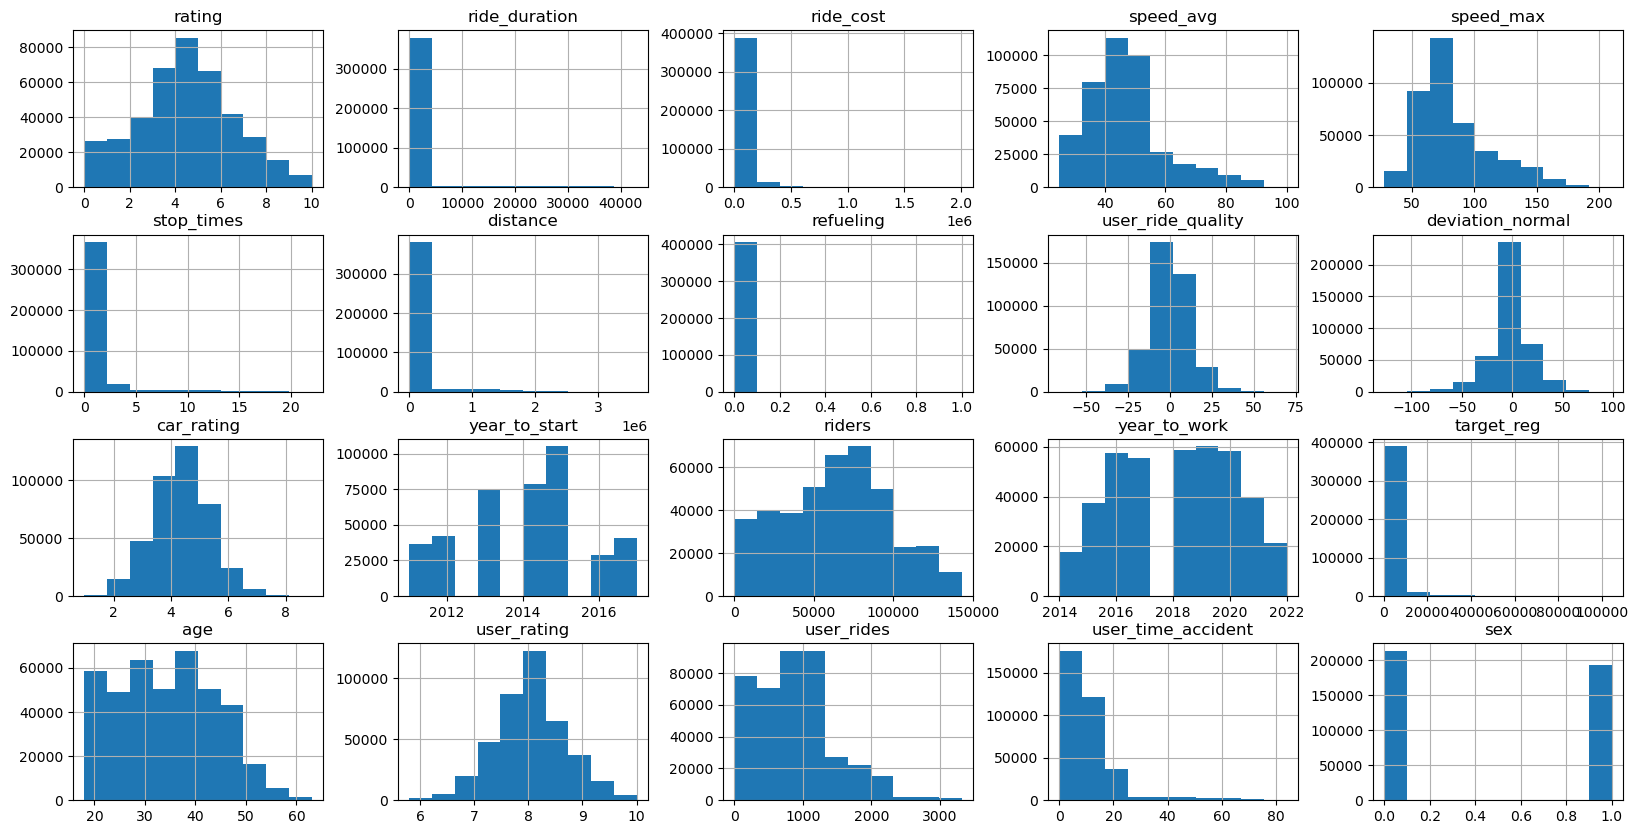

In [24]:
rides_info.hist(figsize=(20, 10), layout=(-1, 5));

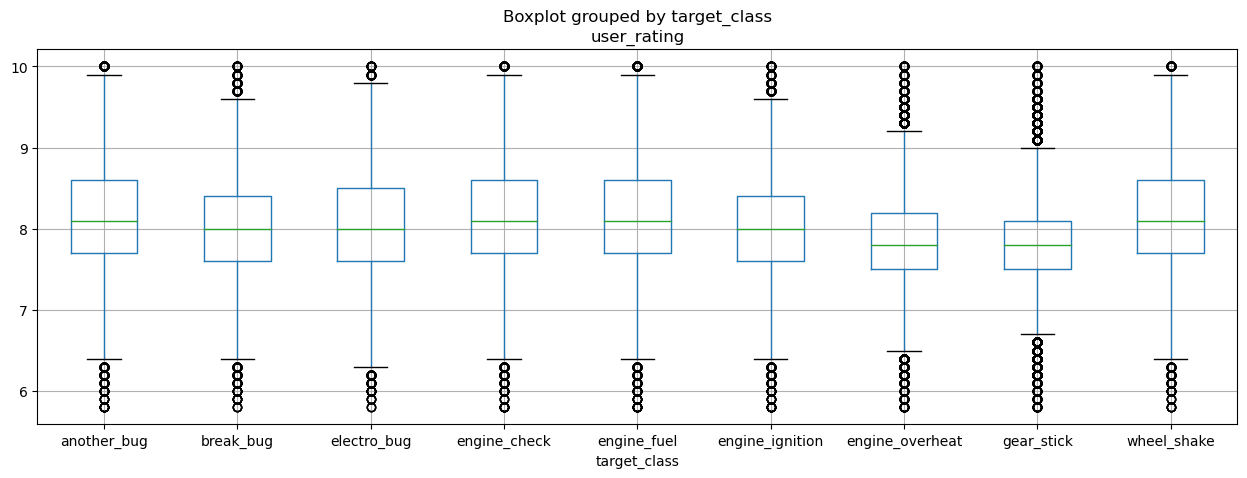

In [33]:
rides_info.boxplot(column='user_rating', by='target_class', figsize=(15, 5));

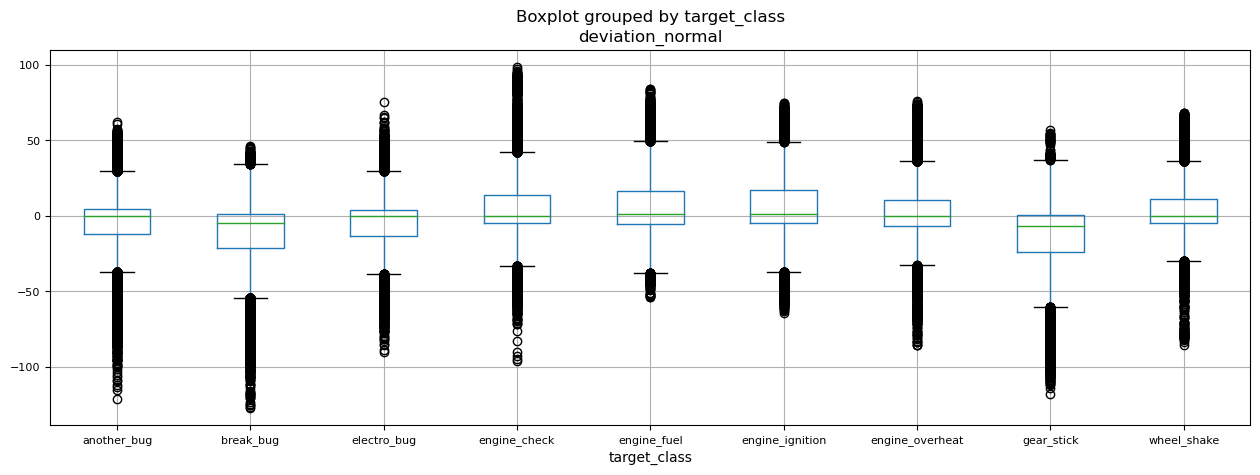

In [36]:
rides_info.boxplot(column='deviation_normal', by='target_class', figsize=(15, 5), fontsize=8);

#### corr

In [42]:
corr = rides_info.corr(numeric_only=True).round(2)
corr.style.background_gradient(cmap='RdYlGn')

In [58]:
rides_info['bin_age'] = pd.cut(rides_info['age'], bins=40, labels=False)

#### cross

In [1]:
# pd.crosstab(
#     rides_info['sex'],
#     rides_info['age'],
#     # normalize=True
# ).style.background_gradient(cmap='RdYlGn',)

In [8]:
pd.crosstab(
    cars['car_type'],
    cars['target_class'],
    # normalize=True
).style.background_gradient(cmap='RdYlGn',)

In [12]:
pd.crosstab(
    cars['model'],
    cars['target_class'],
    # normalize=True
).style.background_gradient(cmap='RdYlGn',)

In [106]:
cars.work_type.value_counts()

work_type
repair              67733
reparking           60533
refuel_check        10136
refuel               7292
oil_change            200
refuel_reparking      106
Name: count, dtype: int64

In [11]:
cars.target_class.value_counts()

engine_overheat    289
gear_stick         284
another_bug        279
engine_check       270
break_bug          270
engine_ignition    269
engine_fuel        262
electro_bug        249
wheel_shake        165
Name: target_class, dtype: int64

In [10]:
sns.set_theme() 

#### deviation and user ride quality by class

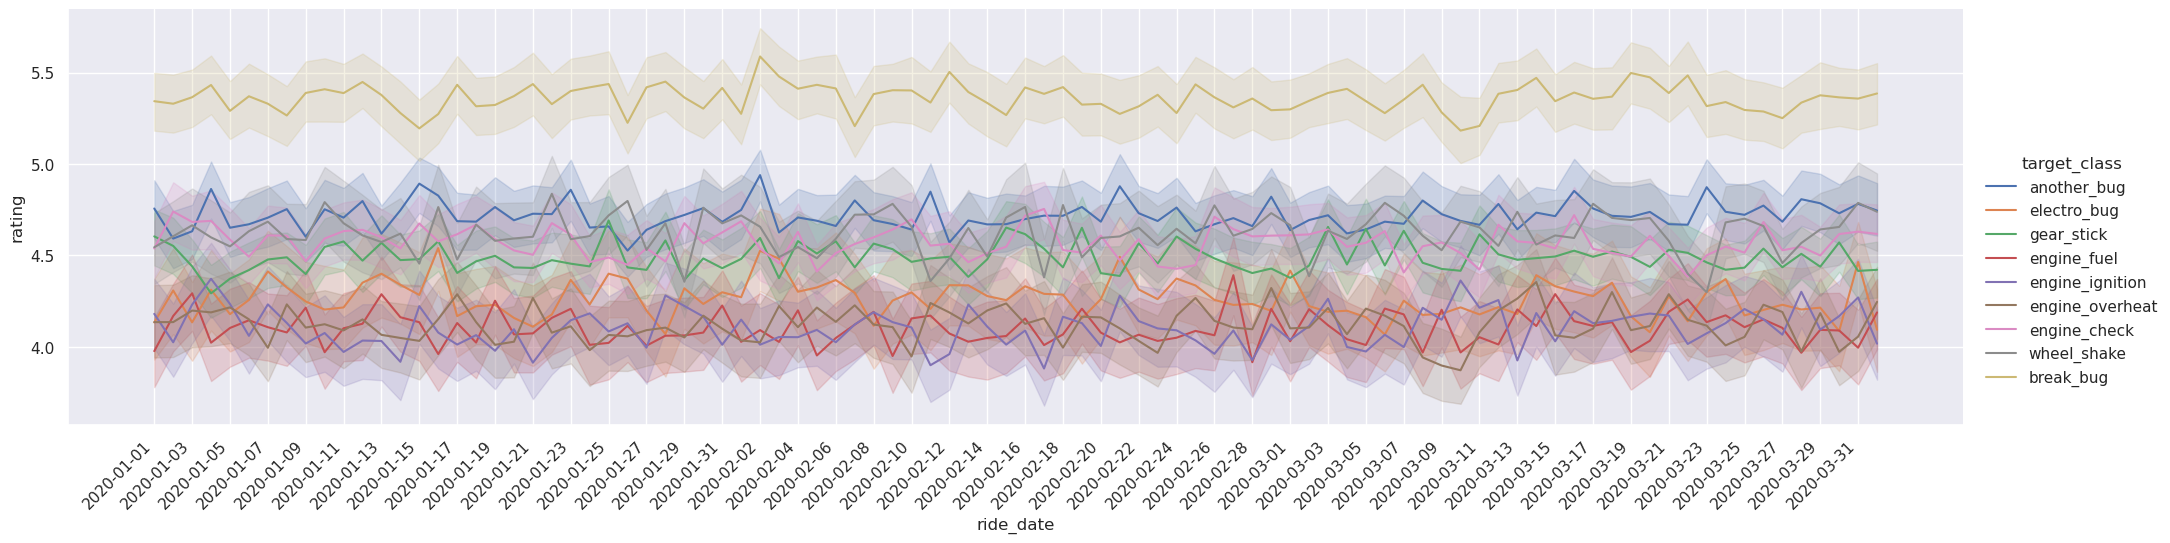

In [12]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='rating',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

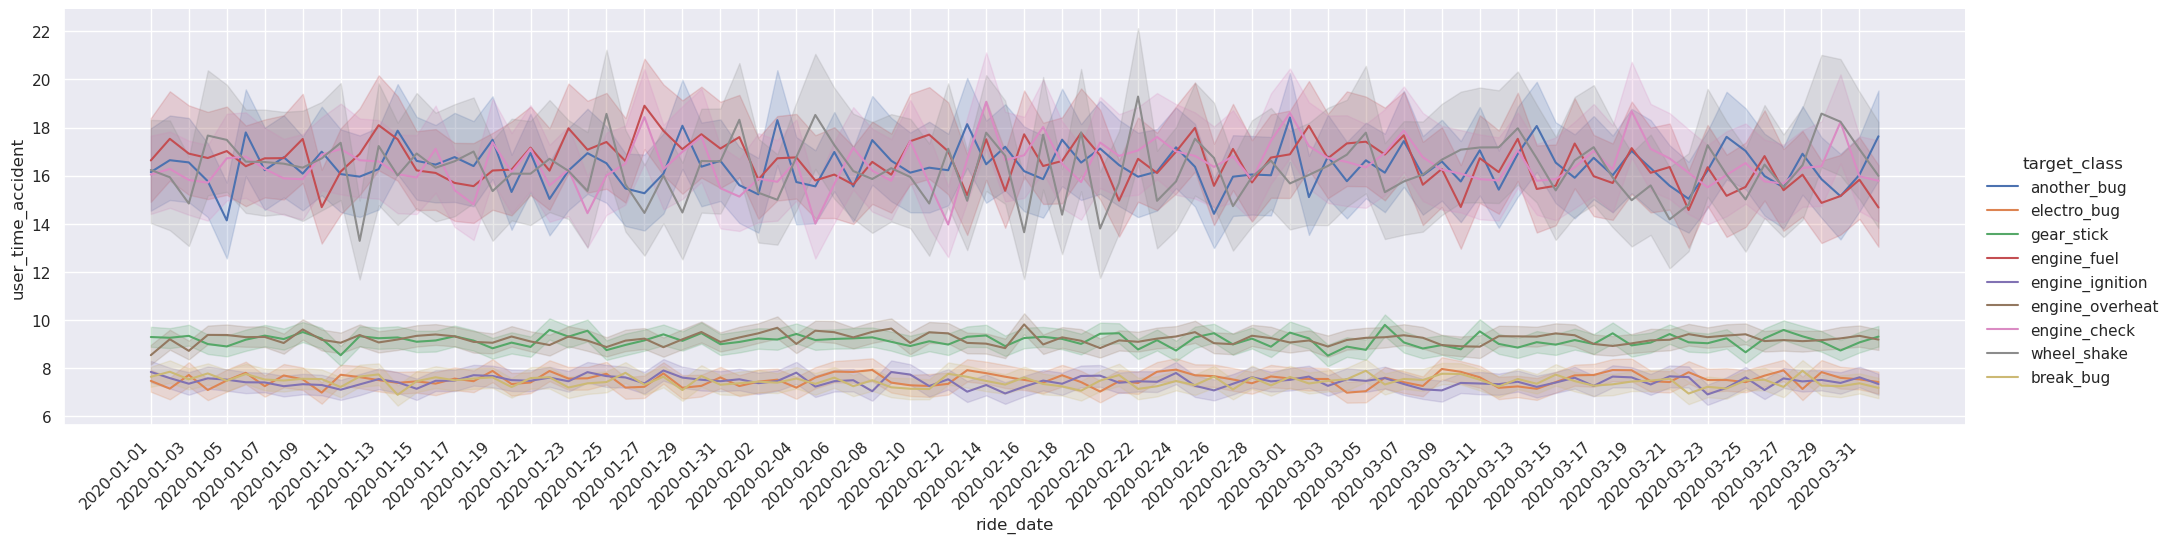

In [11]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='user_time_accident',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

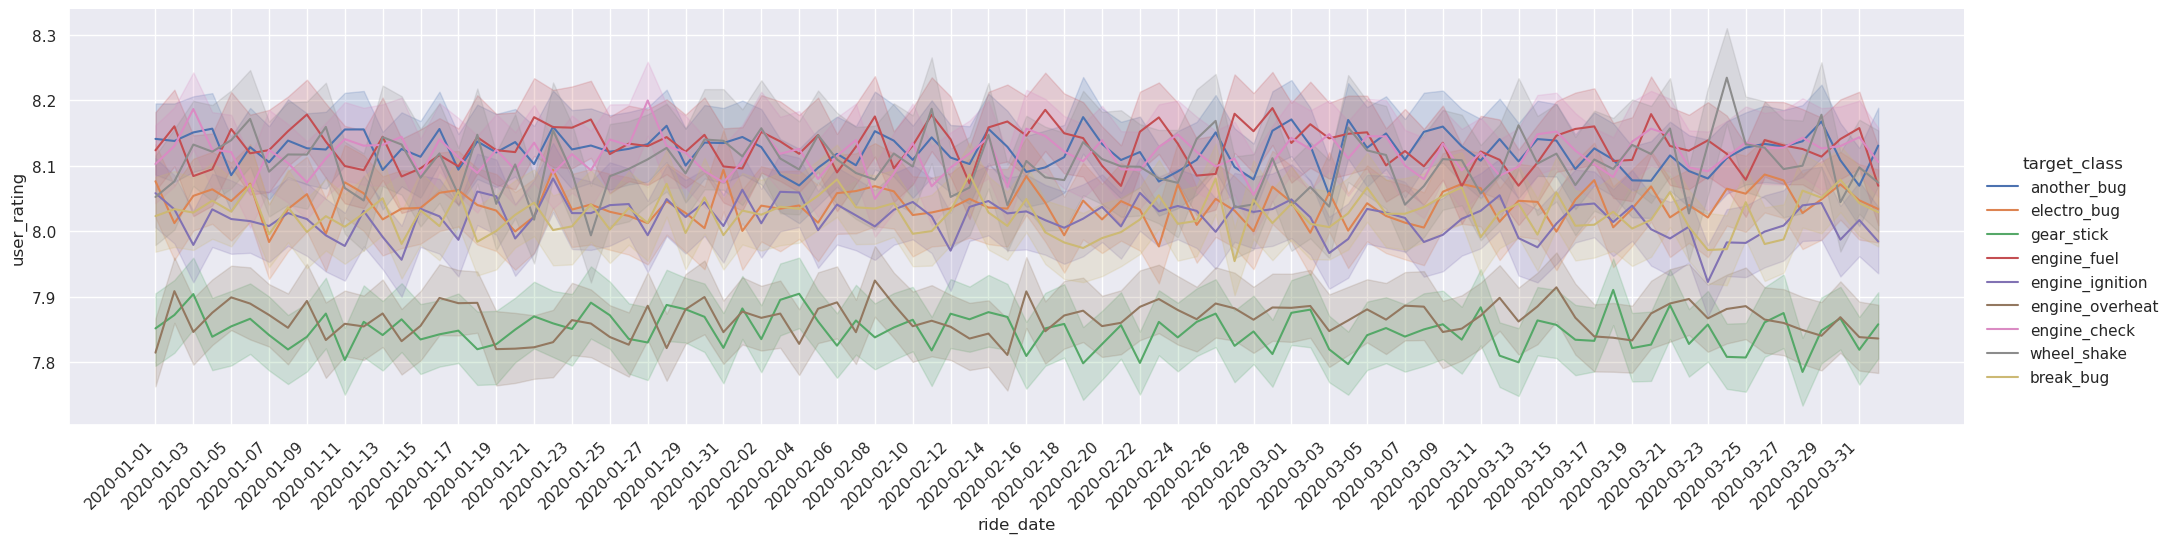

In [65]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='user_rating',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

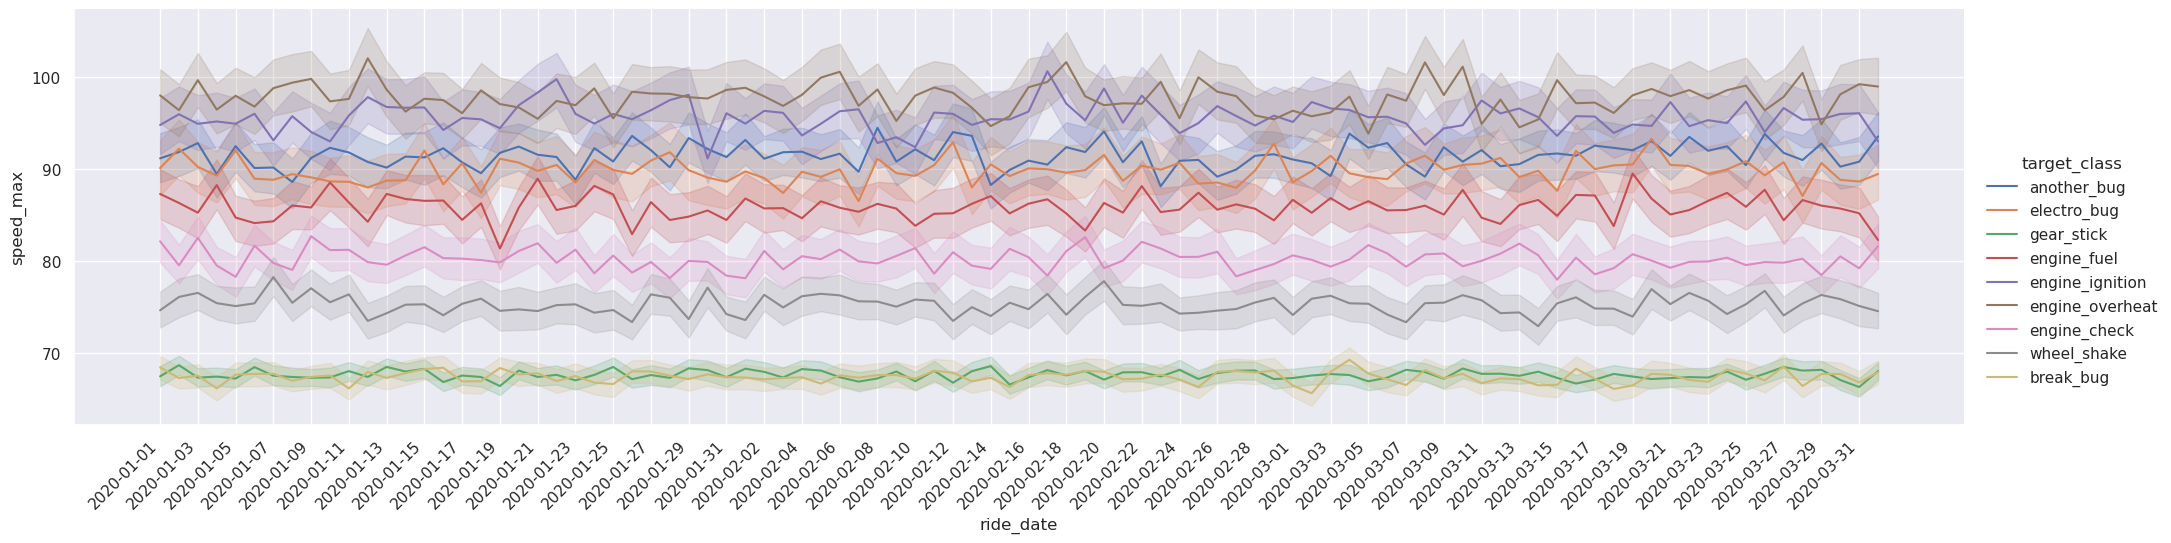

In [46]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='speed_max',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

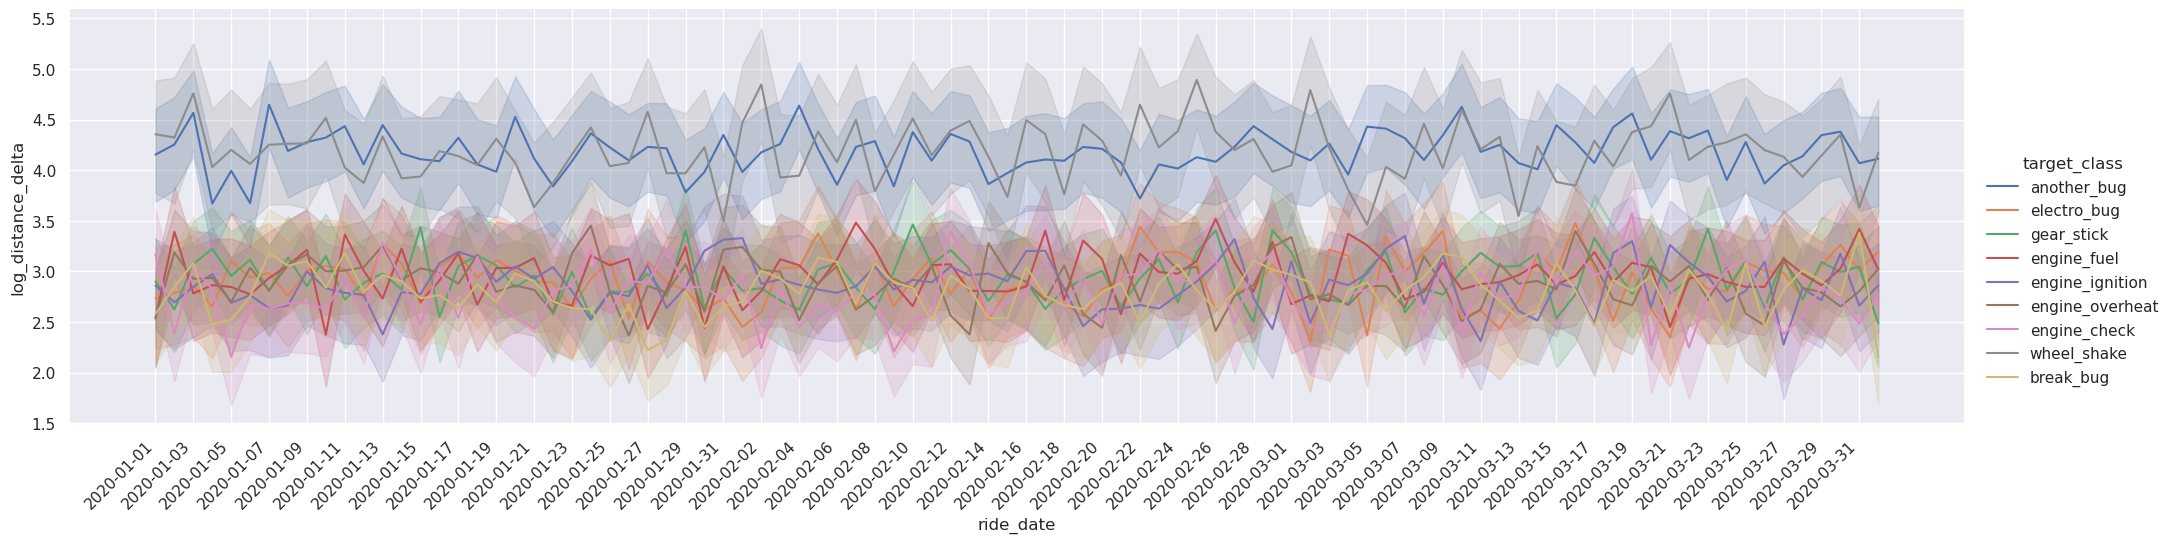

In [45]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='log_distance_delta',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

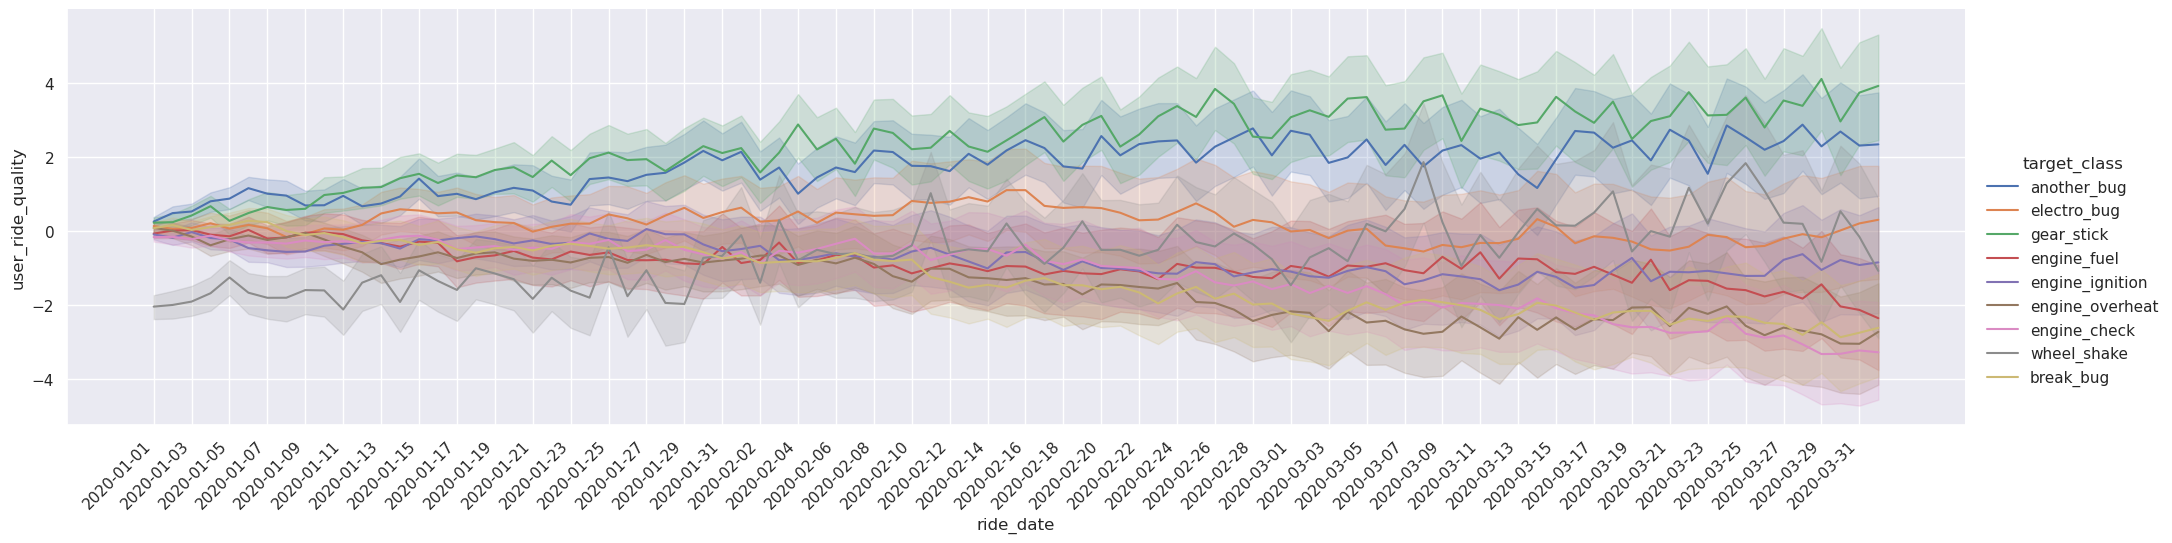

In [94]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='user_ride_quality',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

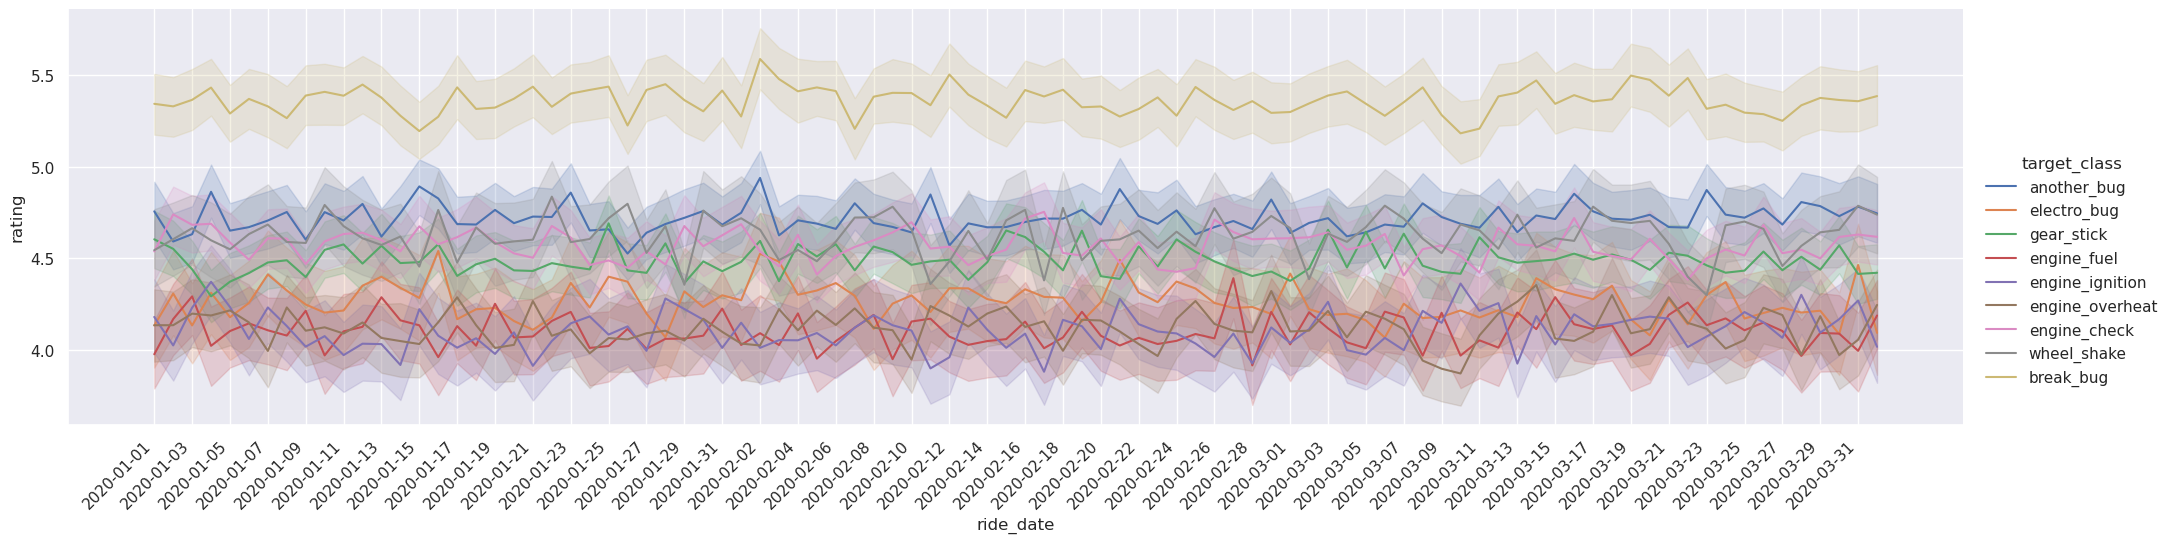

In [96]:
g = sns.relplot(
    data=rides_info,
    x='ride_date',
    y='rating',
    kind='line',
    hue='target_class',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

#### by car

In [179]:
# Отберем информацию только про 10 машин
tmp = rides_info[rides_info["car_id"].isin(rides_info.car_id.unique()[:10])]

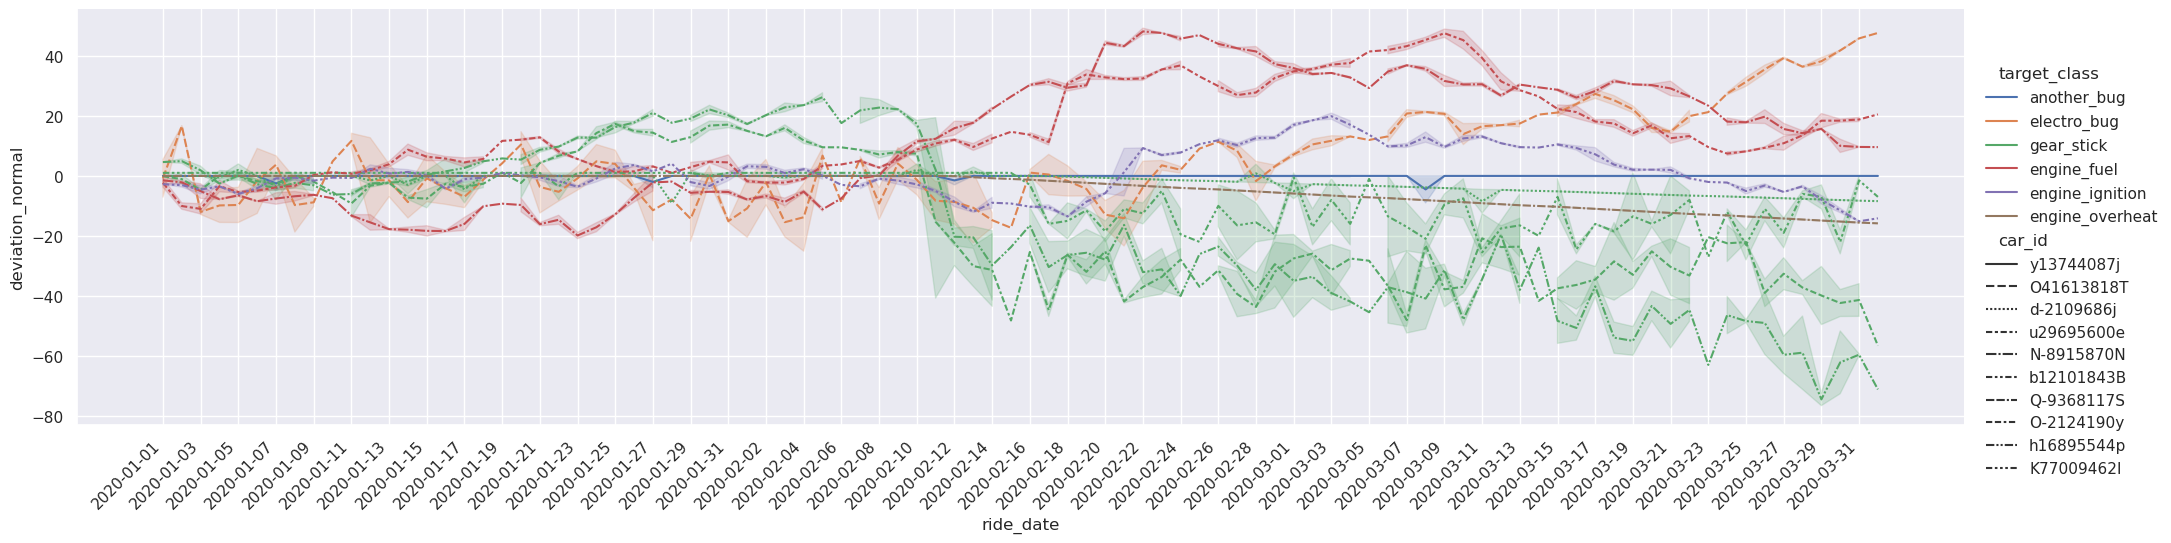

In [180]:
# Как ведет себя deviation_normal во времени для 10 автомобилей

g = sns.relplot(
    data=tmp,
    
    x="ride_date",
    y="deviation_normal",
    
    hue="target_class",
    style="car_id",
    
    legend=True,
    kind="line",
    aspect=4,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

#### by target

In [ ]:
['another_bug', 'electro_bug', 'gear_stick', 'engine_fuel',
       'engine_ignition', 'engine_overheat', 'engine_check',
       'wheel_shake', 'break_bug']

In [202]:
tmp = rides_info[(rides_info.target_class == 'engine_ignition')]
tmp = tmp[tmp["car_id"].isin(tmp.car_id.unique()[:5])]

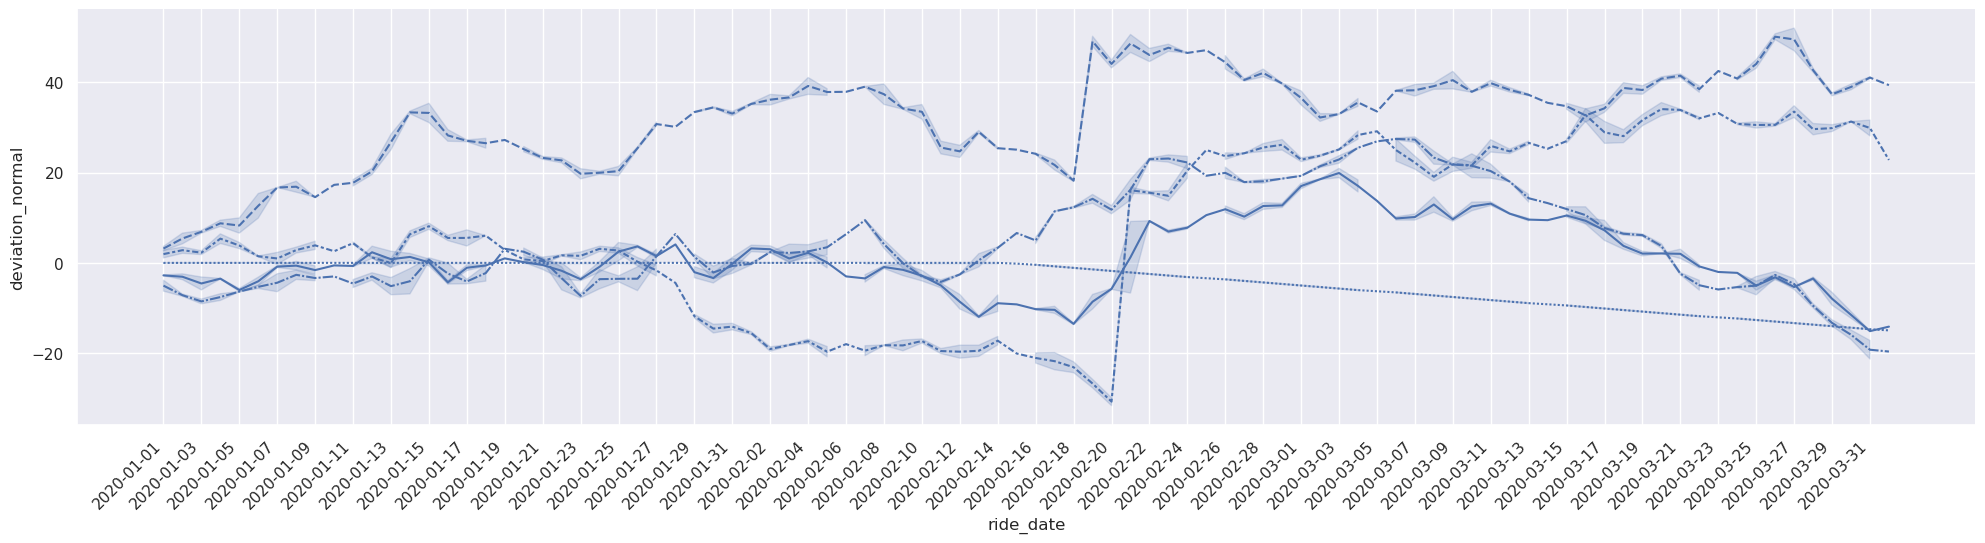

In [203]:
g = sns.relplot(
    data=tmp,
    x="ride_date",
    y="deviation_normal",
    # hue="car_id",
    style="car_id",
    legend=False,
    kind="line",
    aspect=4,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

In [217]:
rides_info['price'] = rides_info['ride_duration'] / rides_info['ride_cost']

In [225]:
rides_info.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'model',
       'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders',
       'year_to_work', 'target_reg', 'target_class', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date', 'bin_age',
       'price'],
      dtype='object')

#### cat plots

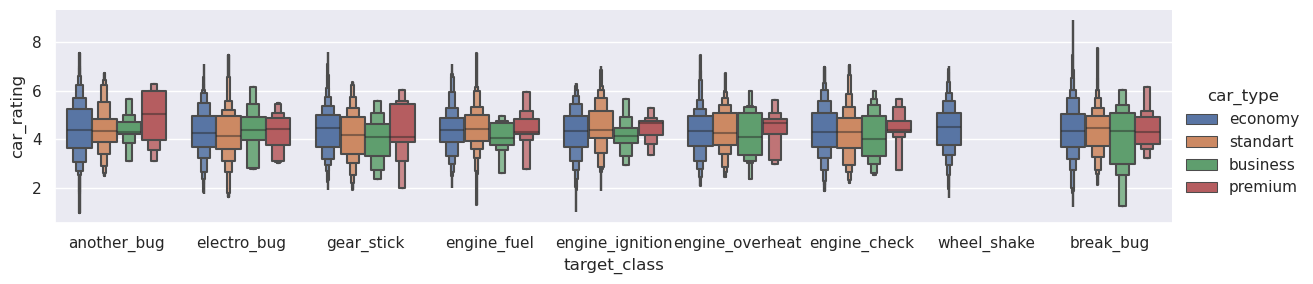

In [257]:
sns.catplot(
    data=rides_info, x="target_class", y="car_rating", hue='car_type',  kind="boxen",
    aspect=4,
    height=3

);

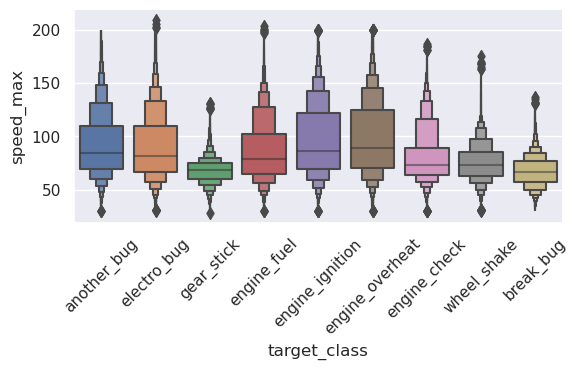

In [63]:
g = sns.catplot(
    data=rides_info, x="target_class", y="speed_max",  kind="boxen",
    aspect=2,
    height=3
)
g.set_xticklabels(rotation=45, );

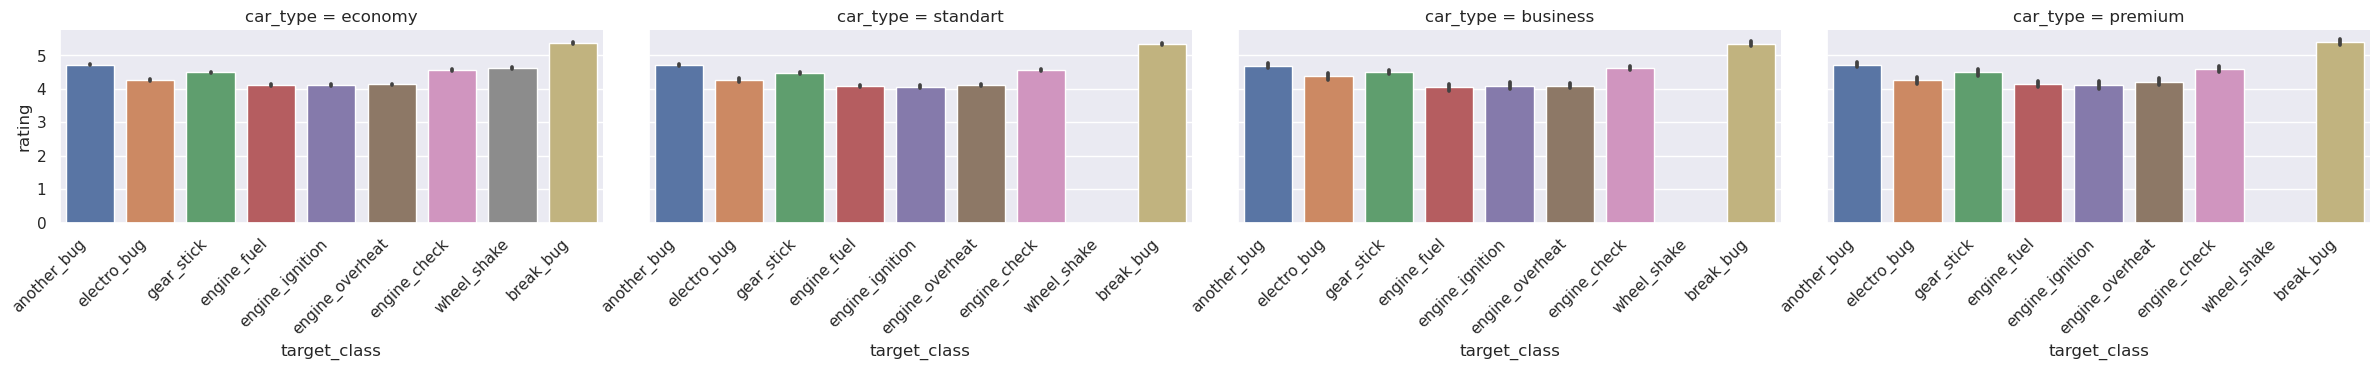

In [269]:
g = sns.catplot(
    data=rides_info, x="target_class", y="rating",  col='car_type',
    aspect=2,
    height=3,
    kind='bar'

);
g.set_xticklabels(rotation=45, horizontalalignment="right");

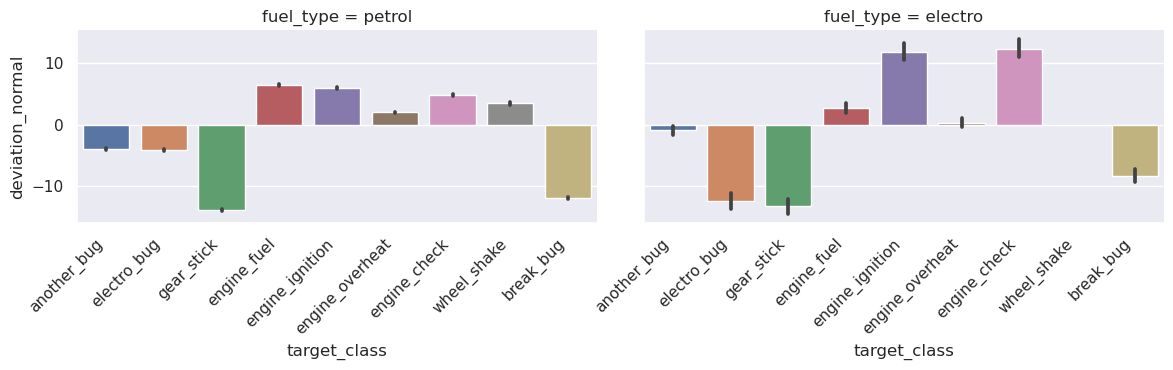

In [272]:
g = sns.catplot(
    data=rides_info, x="target_class", y="deviation_normal",  col='fuel_type',
    aspect=2,
    height=3,
    kind='bar'

);
g.set_xticklabels(rotation=45, horizontalalignment="right");

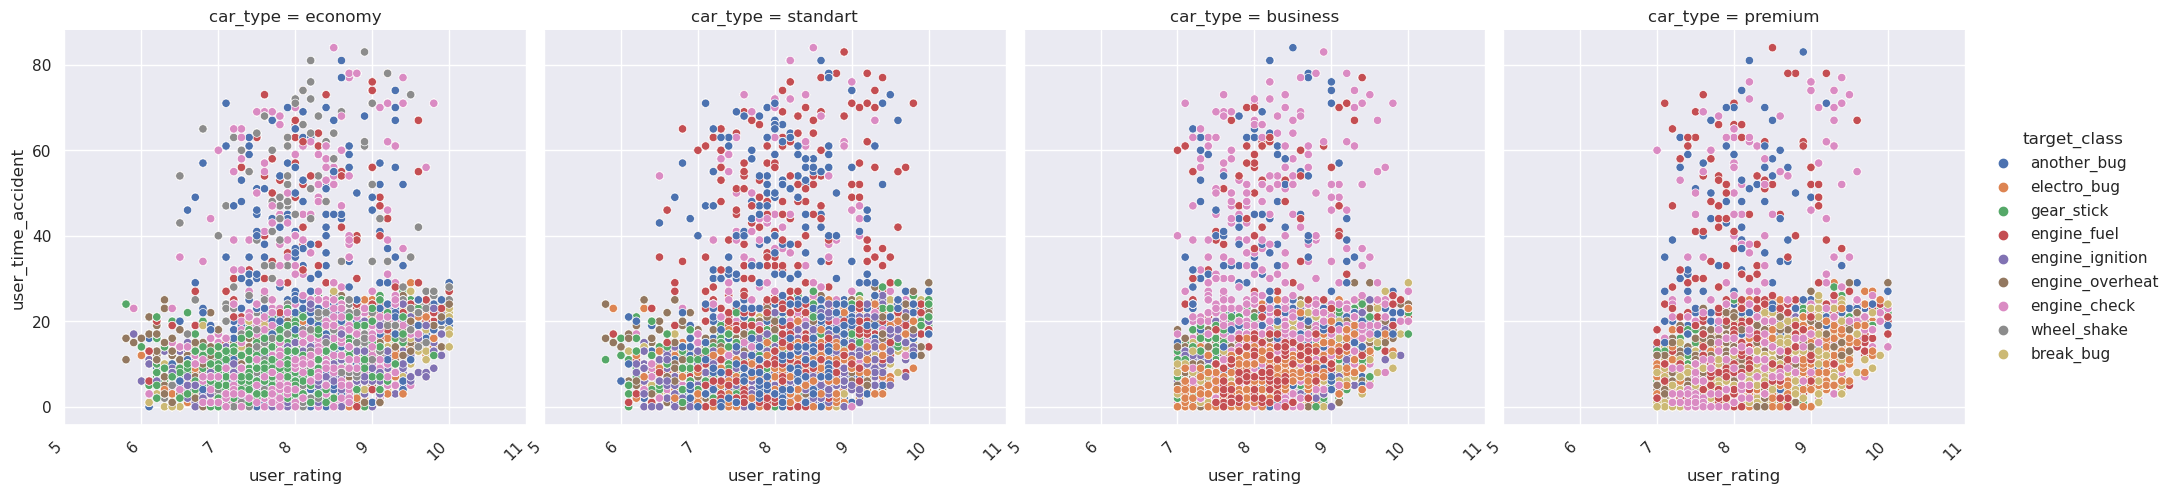

In [279]:
g = sns.relplot(
    data=rides_info, x="user_rating", y="user_time_accident",  col='car_type', hue='target_class'
    # aspect=2,
    # height=3,

);
g.set_xticklabels(rotation=45, horizontalalignment="right");

In [281]:
tmp = rides_info[rides_info.user_time_accident < 20]

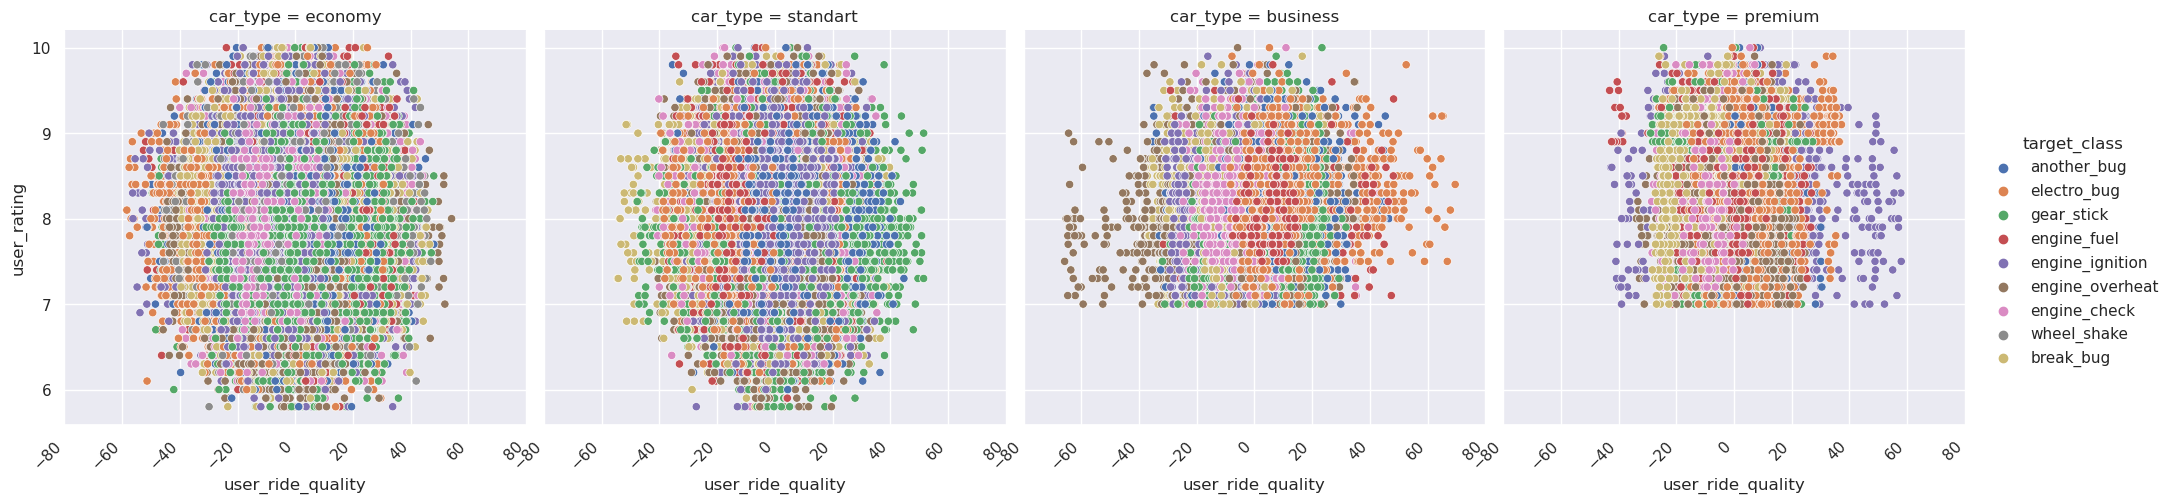

In [284]:
g = sns.relplot(
    data=tmp, x="user_ride_quality", y="user_rating",  col='car_type', hue='target_class'
);
g.set_xticklabels(rotation=45, horizontalalignment="right");

#### 2d distribution

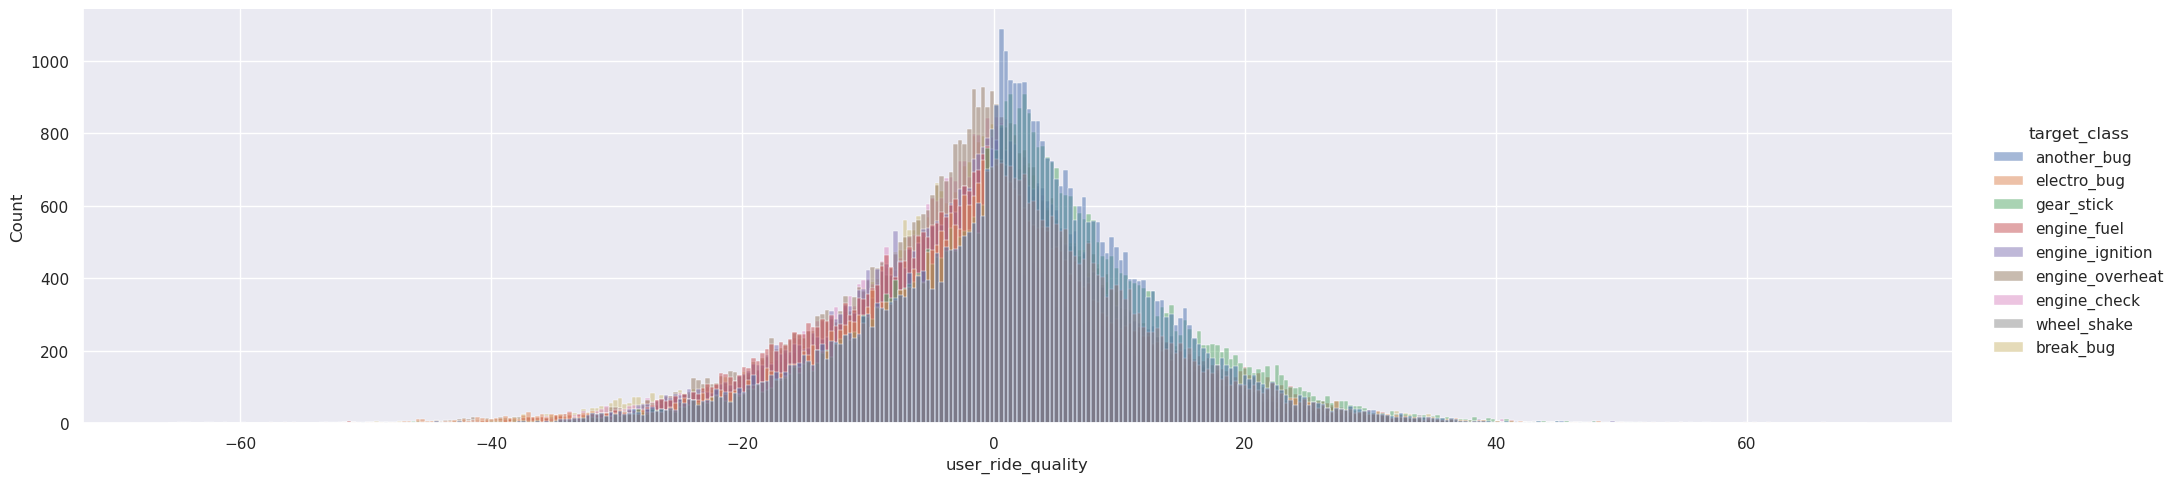

In [13]:
g = sns.displot(
    data=rides_info,
    x="user_ride_quality",
    # y="user_time_accident",
    hue="target_class",
    legend=True,
    aspect=4,
    kind="hist",  # kde
    alpha=0.5,
);

In [27]:
tmp = rides_info[rides_info["car_id"].isin(rides_info.sample(300, random_state=10).car_id.unique()[:100])]

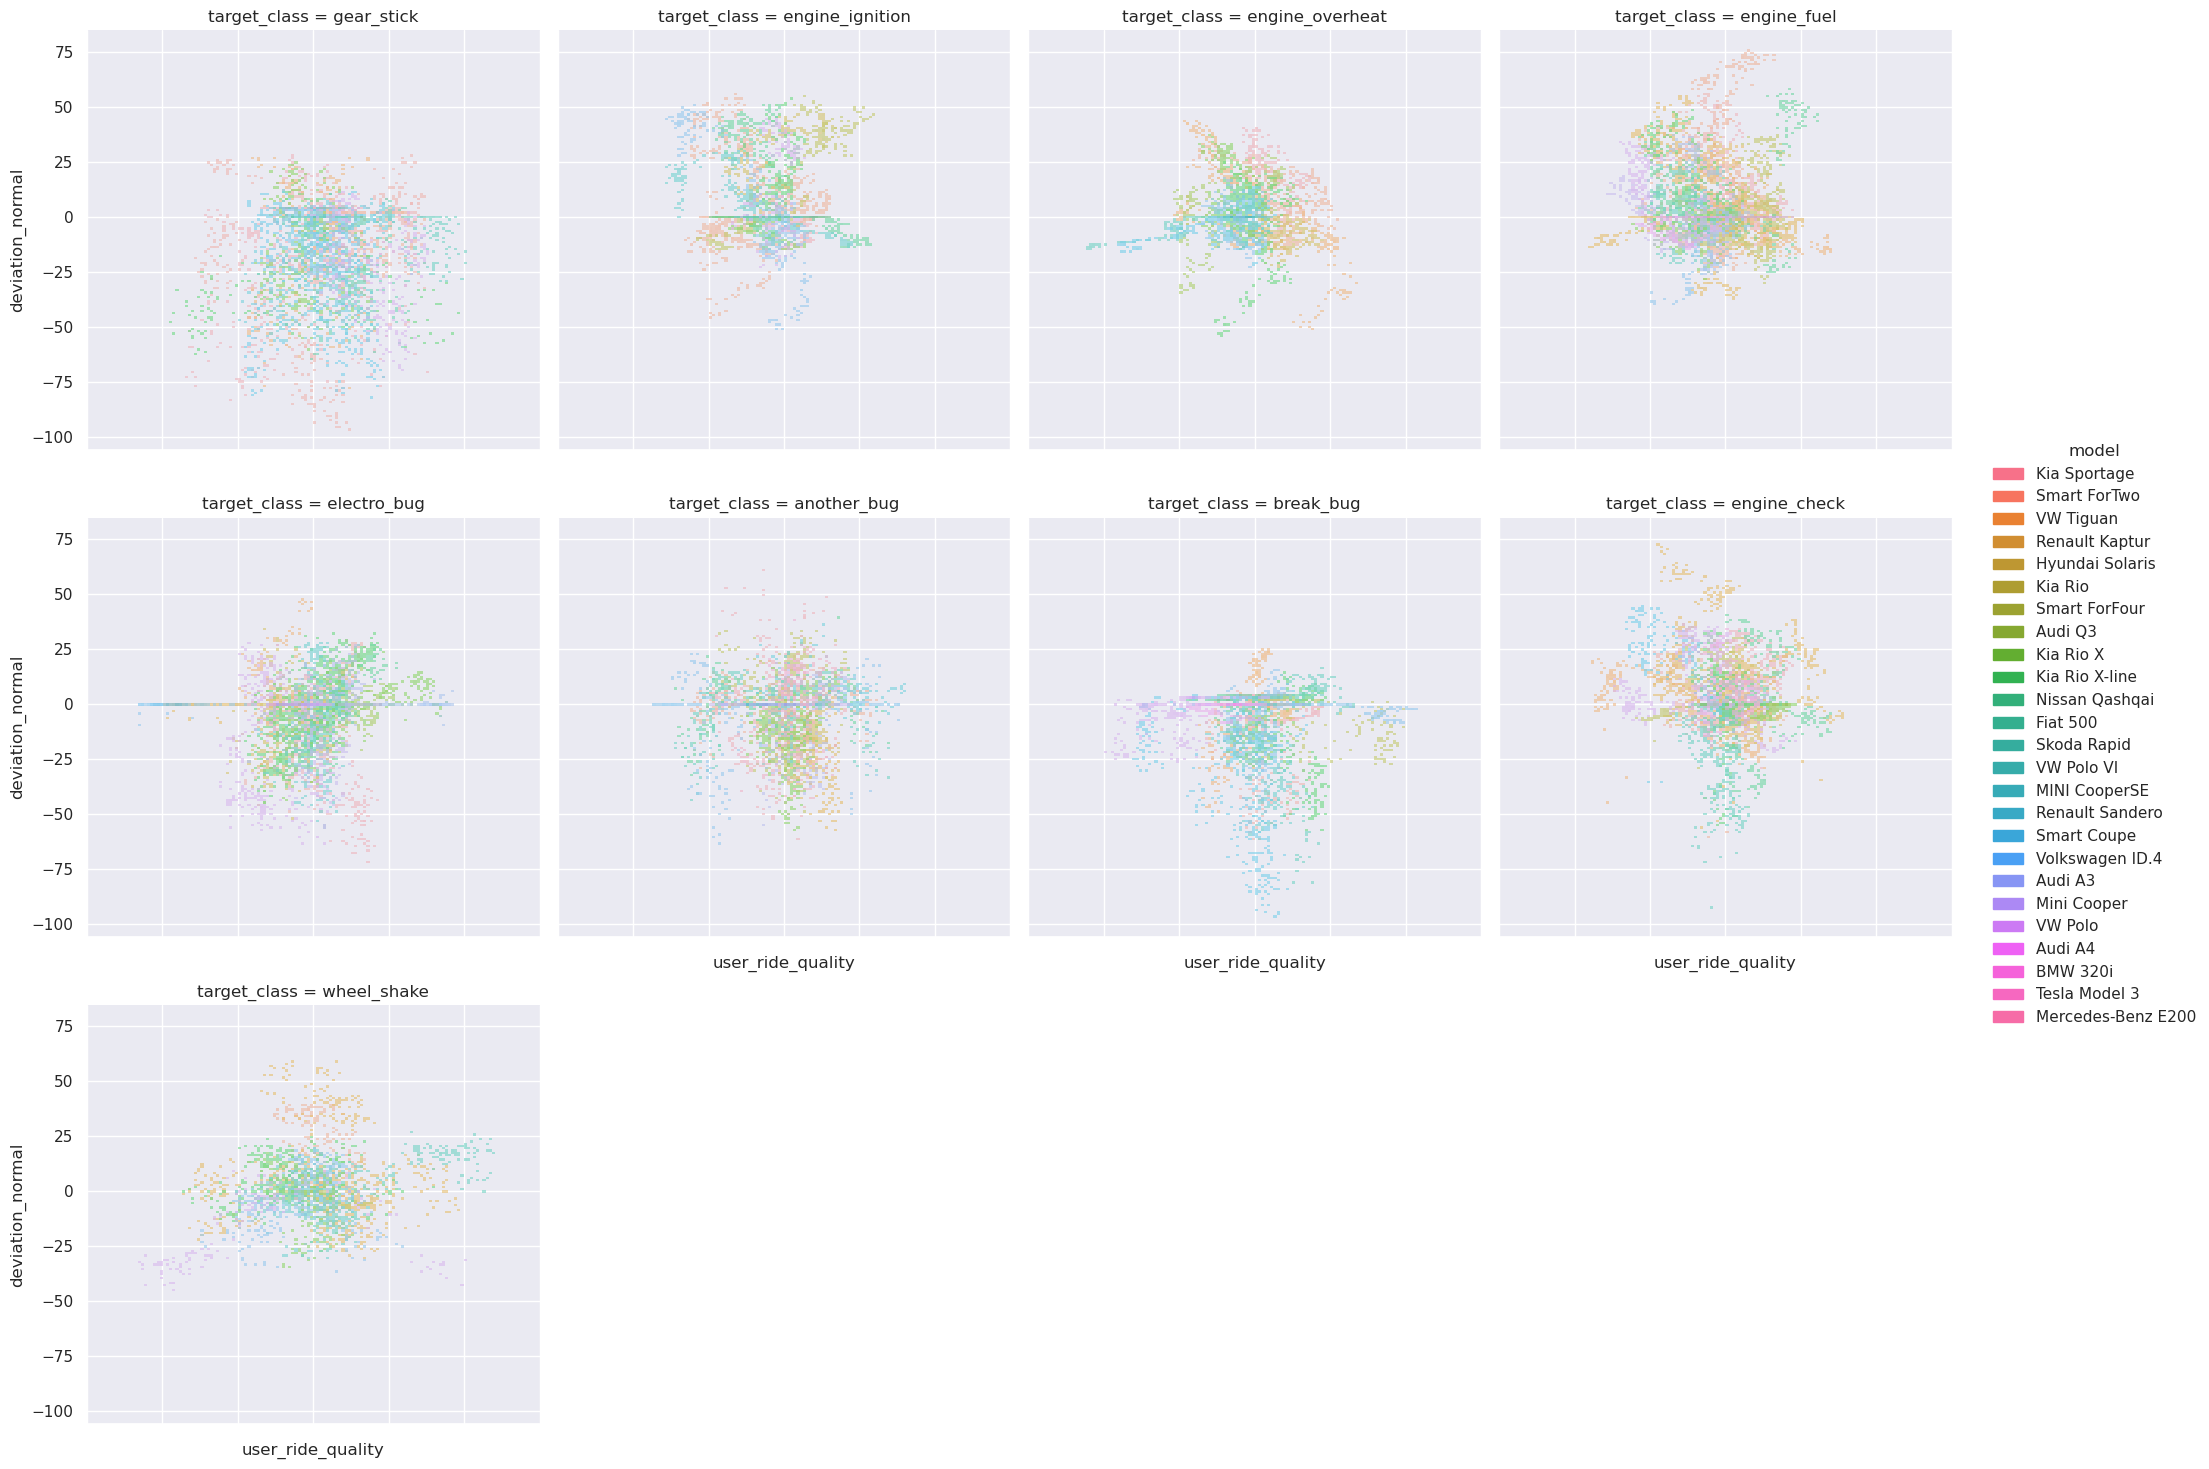

In [32]:
g = sns.displot(
    data=tmp,
    
    x="user_ride_quality",
    y="deviation_normal",
    
    aspect=1,
    # kind="kde",
    alpha=0.6,
    
    hue="model",
    col="target_class",
    # legend=False,
    
    col_wrap=4,
    
).set_xticklabels(rotation=45, horizontalalignment="right");

In [34]:
rides_info.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'model',
       'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders',
       'year_to_work', 'target_reg', 'target_class', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date'],
      dtype='object')

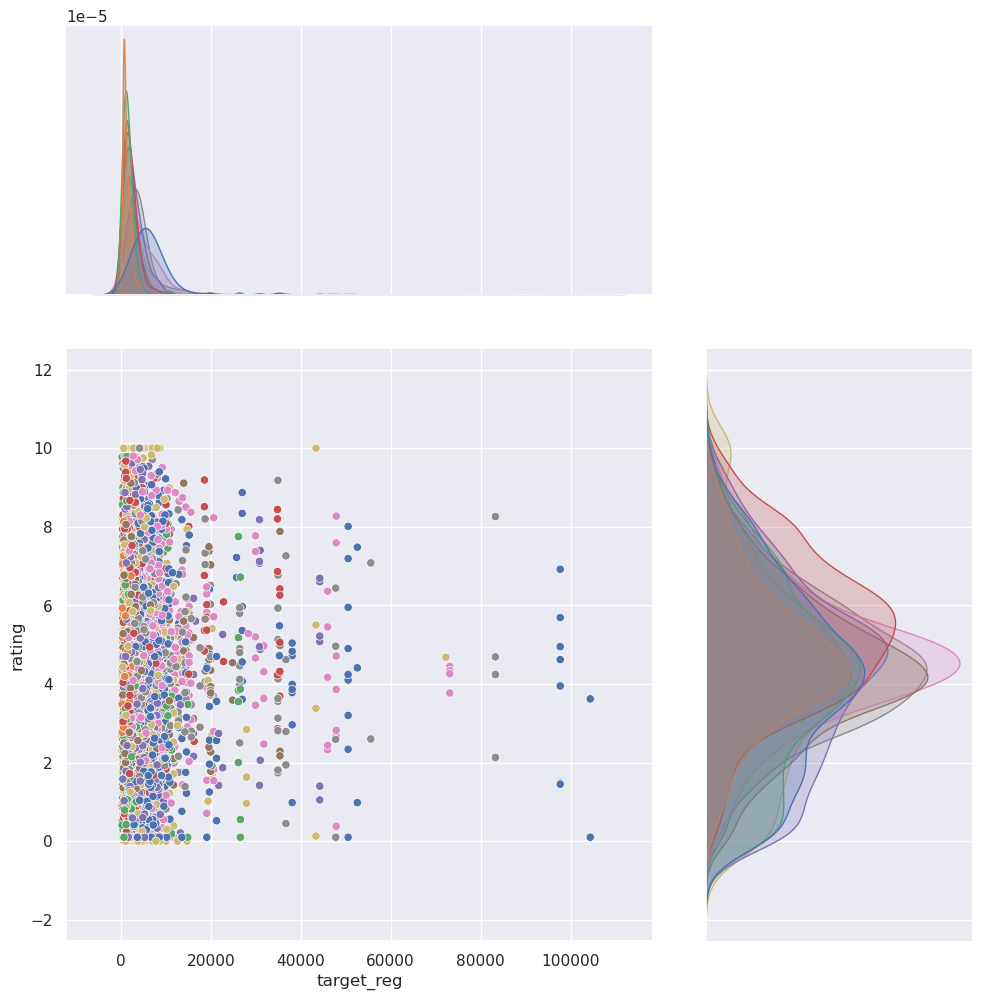

In [40]:
# Диаграмма рассеяния + распределения

sns.jointplot(
    data=rides_info.sample(10_000),
    x="target_reg",
    y="rating",
    hue="target_class",
    height=10,
    legend=False,
    ratio=2,
    kind="scatter",
);

### fixes

In [ ]:
fix_types = ['reparking', 'repair', 'refuel_check', 'refuel', 'oil_change',
       'refuel_reparking']
interesting_fixes = ['repair']

fixes = fixes[fixes.work_type.isin(interesting_fixes)]
fixes = fixes[fixes.fix_date < '2020-04-01']

############################################################################
last_fixes  = fixes.groupby('car_id') \
                    .apply(lambda x: x['fix_date'].iloc[-1]) \
                    .rename('fix_date').reset_index()
avg_destroy_degree  = fixes.groupby('car_id').apply(lambda x: x['destroy_degree'].median()).rename('destroy_degree').reset_index()

cars_fixes = cars.merge(last_fixes, on='car_id', how='left').merge(avg_destroy_degree, on='car_id', how='left')
cars_fixes['fix_date'] = pd.to_datetime(
    cars_fixes['fix_date'],
    format='%Y-%m-%d', errors='coerce'
).dt.date

g = sns.relplot(
    data=cars_fixes,
    x='fix_date',
    y='destroy_degree',
    hue='target_class',
    kind='scatter',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);